# Visualize pressure-volume (PV) curves
This notebook loads a raw `.edf` sensor file, selects a time window, integrates flow to obtain volume, and finally draws the PV curve (pressure vs. integrated volume). Configure the EDF path and window parameters in the last cell before running.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append(os.path.abspath(".."))

from util.multimodal_align import read_sensor_tsv_edf

plt.rcParams['figure.dpi'] = 120


In [2]:
def _resolve_column(df: pd.DataFrame, hint: str, description: str) -> str:
    """Return the column name that matches hint exactly or by prefix."""
    if hint is None:
        raise ValueError(f"No {description} hint provided.")
    if hint in df.columns:
        return hint
    candidates = [c for c in df.columns if c.startswith(hint)]
    if not candidates:
        candidates = [c for c in df.columns if c.lower().startswith(hint.lower())]
    if not candidates:
        available = ', '.join(df.columns[:10])
        raise ValueError(f"Could not find {description} matching '{hint}'. Available columns (first 10): {available}")
    if len(candidates) > 1:
        candidates.sort(key=len, reverse=True)
    return candidates[0]


def load_sensor_frame(edf_path: str, flow_col: str, press_col: str, time_col: str = "Epoch_UTC") -> tuple[pd.DataFrame, str, str, str]:
    df = read_sensor_tsv_edf(edf_path)
    time_name = _resolve_column(df, time_col, "time column")
    flow_name = _resolve_column(df, flow_col, "flow column")
    press_name = _resolve_column(df, press_col, "pressure column")
    return df, flow_name, press_name, time_name


def select_sensor_window(
    df: pd.DataFrame,
    time_col: str = "Epoch_UTC",
    start_utc: float | None = None,
    duration_sec: float | None = None,
    start_index: int | None = None,
    num_samples: int | None = None,
) -> pd.DataFrame:
    window = df
    if start_utc is not None and duration_sec is not None:
        end_utc = start_utc + duration_sec
        mask = (df[time_col] >= start_utc) & (df[time_col] <= end_utc)
        window = df.loc[mask]
    elif start_index is not None:
        end_idx = start_index + num_samples if num_samples is not None else None
        window = df.iloc[start_index:end_idx]
    return window.reset_index(drop=True)


def compute_volume_from_flow(
    df: pd.DataFrame,
    flow_col: str,
    time_col: str = "Epoch_UTC"
) -> tuple[np.ndarray, np.ndarray]:
    """Integrate flow to get volume and remove slow baseline drift."""
    time_s = df[time_col].to_numpy(dtype=float)
    time_rel = time_s - time_s[0]
    flow_slm = df[flow_col].to_numpy(dtype=float)
    flow_lps = flow_slm / 60.0  # convert standard L/min -> L/s
    dt = np.diff(time_rel, prepend=0.0)
    volume_l = np.cumsum(flow_lps * dt)
    volume_l -= volume_l[0]

    if len(volume_l) > 1:
        slope, intercept = np.polyfit(time_rel, volume_l, 1)
        drift = slope * time_rel + intercept
        volume_l = volume_l - drift
        volume_l -= volume_l[0]

    return time_rel, volume_l


def plot_flow_and_pressure(
    df: pd.DataFrame,
    time_rel: np.ndarray,
    flow_col: str,
    press_col: str
) -> None:
    fig, ax_flow = plt.subplots(figsize=(10, 4))
    ln1 = ax_flow.plot(time_rel, df[flow_col], color="tab:blue", label="Flow (slm)")
    ax_flow.axhline(0.0, color="tab:blue", linestyle="--", linewidth=0.5)
    ax_flow.set_xlabel("Time (s)")
    ax_flow.set_ylabel("Flow (slm)", color="tab:blue")

    ax_press = ax_flow.twinx()
    ln2 = ax_press.plot(time_rel, df[press_col], color="tab:orange", linestyle="--", label="Pressure (Pa)")
    ax_press.axhline(0.0, color="tab:orange", linestyle=":", linewidth=0.5)
    ax_press.set_ylabel("Pressure (Pa)", color="tab:orange")

    lines = ln1 + ln2
    labels = [l.get_label() for l in lines]
    ax_flow.legend(lines, labels, loc="best")
    ax_flow.set_title("Flow / Pressure")
    fig.tight_layout()
    plt.show()


def plot_pv_curve(
    volume_l: np.ndarray,
    pressure: np.ndarray,
    color: str = "#8bc34a",
    alpha: float = 0.55,
) -> None:
    """Draw PV curve with a light color so repeated loops stay readable."""
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(volume_l, pressure, color=color, alpha=alpha, linewidth=2.0)
    ax.set_xlabel("Volume (L)")
    ax.set_ylabel("Pressure (Pa)")
    ax.set_title("Pressure–Volume curve")
    ax.grid(True, linestyle=":", alpha=0.5)
    plt.show()

Loaded 88,674 samples, window has 3,000 samples


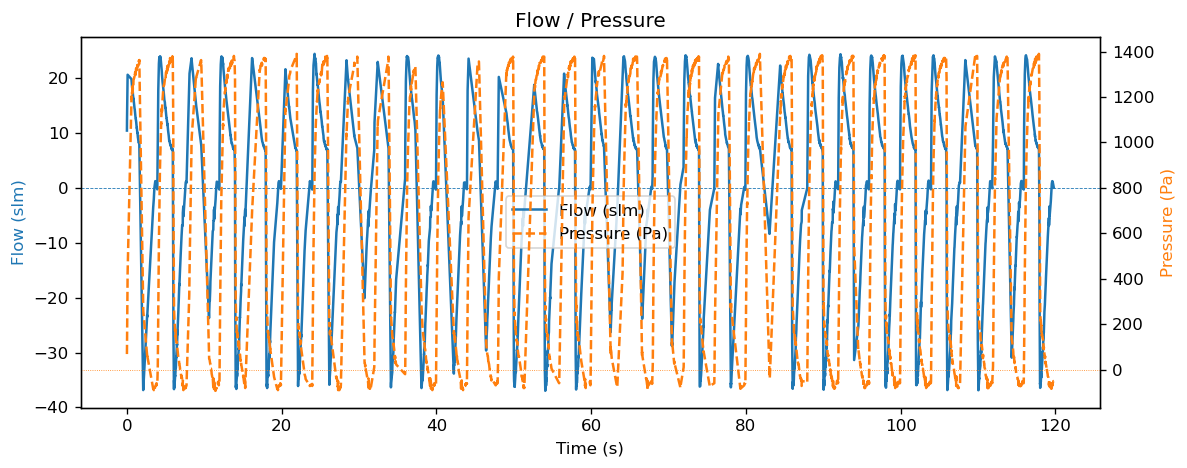

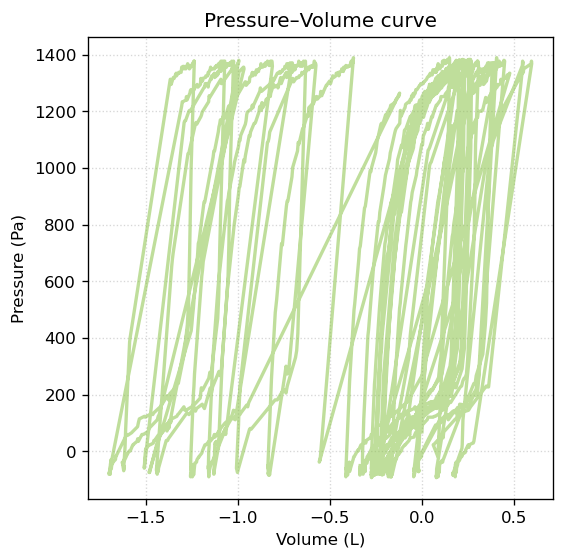

In [5]:
# --- Configuration ---
edf_path = os.path.join("..", "MMDataset", "251026", "2025-10-26_18-47-52-SFM3300AW_24410080.edf")
edf_path = os.path.join("..", "MMDataset", "251130", "2025-11-30_23-21-23-SFM3300AW_24400737.edf")
flow_col = "F_SFM3300AW_"
press_col = "P_SFM3300AW_"
time_col = "Epoch_UTC"

# Choose one of the following window specs before running:
start_utc = None        # e.g. 1761475725.0
duration_sec = None     # seconds, must be set together with start_utc
start_index = 30000        # alternatively use row indices
num_samples = 3000      # set to None to read till end

# --- Load, slice, and plot ---
df, flow_col, press_col, time_col = load_sensor_frame(edf_path, flow_col, press_col, time_col=time_col)
window = select_sensor_window(
    df,
    time_col=time_col,
    start_utc=start_utc,
    duration_sec=duration_sec,
    start_index=start_index,
    num_samples=num_samples,
)
print(f"Loaded {len(df):,} samples, window has {len(window):,} samples")

if len(window) < 2:
    raise RuntimeError("Selected window is empty. Adjust the configuration above.")

relative_time_s, volume_l = compute_volume_from_flow(window, flow_col, time_col=time_col)
pressure = window[press_col].to_numpy(dtype=float)

plot_flow_and_pressure(window, relative_time_s, flow_col, press_col)
plot_pv_curve(volume_l, pressure)